In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyodbc
import regex as re

In [73]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select b.description, c.description, d.description from DatixCRM.dbo.code_unit b join DatixCRM.dbo.incidents_main a on a.inc_unit = b.code join DatixCRM.dbo.code_specialty c on a.inc_specialty = c.code join DatixCRM.dbo.code_locactual d on a.inc_locactual=d.code where a.inc_type='PAT' and a.inc_category='MEDIC' and a.inc_organisation='QA' and d.cod_parent2='QA'"
df = pd.read_sql(query, sql_conn)
df.columns = ['division-care_group','specialty','location']
df.head()

,division-care_group,specialty,location
0,Medicine & Urgent Care Division - Medicine,Respiratory,E6/7
1,Medicine & Urgent Care Division - Medicine,General Medicine,C5
2,Medicine and Urgent Care Division - Urgent Care,Emergency Department,Emergency Department (ED)
3,Medicine & Urgent Care Division - Medicine,Cardiology,C7
4,Surgical and Outpatients Division - MSK / Head...,Orthopaedic,D5


In [74]:
df['division-care_group'] = df['division-care_group'].str.replace(' and ',' & ')
df['specialty'] = df['specialty'].str.replace(' and ',' & ')
df['specialty'] = df['specialty'].str.replace('/ ','/')
divider = df['division-care_group'].str.split(" Division - ",n=1,expand=True)
df['division'] = divider[0]
df['care_group'] = divider[1]
#df['division'] = df['division'].str.replace(' and ',' & ')
df.loc[df.division == 'Corporate Functions', 'care_group'] = 'Corporate Functions'
df = df[df['division-care_group'] != 'Corporate Functions']
df = df[df.care_group != 'Pathology']
df = df[df.care_group != 'Patient Administration Services']
#df.loc[df.division == 'Surgical & Outpatients', 'division'] = 'Surgical & Outpatients + Corporate Functions'
#df.loc[df.division == 'Corporate Functions', 'division'] = 'Surgical & Outpatients + Corporate Functions'

In [75]:
division_counts = df['division'].value_counts()
division_percentages = 100*division_counts/sum(division_counts.values)
division_labels = [str(i) for i in division_counts.index]
print(division_percentages)

Medicine & Urgent Care    45.434199
Networked Services        20.646822
Clinical Delivery         17.054611
Surgical & Outpatients    16.864369
Name: division, dtype: float64


In [76]:
df['division_sorted'] = pd.Categorical(df['division'], division_labels)
df = df.sort_values("division_sorted")
df.head()

,division-care_group,specialty,location,division,care_group,division_sorted
0,Medicine & Urgent Care Division - Medicine,Respiratory,E6/7,Medicine & Urgent Care,Medicine,Medicine & Urgent Care
4575,Medicine & Urgent Care Division - Urgent Care,Emergency Department,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care
4573,Medicine & Urgent Care Division - Urgent Care,Acute Medicine for Older People,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care
4567,Medicine & Urgent Care Division - Older Person...,Acute Medicine for Older People,G3,Medicine & Urgent Care,Older Persons Medicine,Medicine & Urgent Care
4564,Medicine & Urgent Care Division - Medicine,Pharmacy,Respiratory Day Unit,Medicine & Urgent Care,Medicine,Medicine & Urgent Care


In [77]:
care_group_labels = []
for i in division_counts.index:
    df_division = df[df.division == i]
    per_division_counts = df_division['care_group'].value_counts()
    care_group_labels += [str(i) for i in per_division_counts.index]
print(care_group_labels)

['Urgent Care', 'Medicine', 'Older Persons Medicine', "Women & Children's", 'Regional Cancer Centre', 'Renal & Transplantation', 'Pharmacy', 'Critical Care, Theatres, Anaesthetics & HSDU', 'Imaging Radiology', 'MSK / Head & Neck', 'Surgery']


In [78]:
df['care_group_sorted'] = pd.Categorical(df['care_group'], care_group_labels)
df = df.sort_values(['division_sorted','care_group_sorted'])
df.head()

,division-care_group,specialty,location,division,care_group,division_sorted,care_group_sorted
4575,Medicine & Urgent Care Division - Urgent Care,Emergency Department,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
4573,Medicine & Urgent Care Division - Urgent Care,Acute Medicine for Older People,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
4562,Medicine & Urgent Care Division - Urgent Care,Emergency Department,Emergency Department (ED),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
4552,Medicine & Urgent Care Division - Urgent Care,General Medicine,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care
4536,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care


In [79]:
care_group_counts = df['care_group'].value_counts()[df['care_group'].unique()]
care_group_percentages = 100*care_group_counts/sum(care_group_counts.values)
print(care_group_percentages)

Urgent Care                                     18.912265
Medicine                                        17.558192
Older Persons Medicine                           8.963742
Women & Children's                              10.060430
Regional Cancer Centre                           7.038944
Renal & Transplantation                          3.547449
Pharmacy                                        11.817368
Critical Care, Theatres, Anaesthetics & HSDU     4.297225
Imaging Radiology                                0.940018
MSK / Head & Neck                                9.568039
Surgery                                          7.296329
Name: care_group, dtype: float64


In [80]:
specialty_counts = df['specialty'].value_counts()[df['specialty'].unique()]
print(specialty_counts.index)

Index(['Emergency Department', 'Acute Medicine for Older People',
       'General Medicine', 'Acute Medical Unit', 'Paediatrics', 'Orthopaedic',
       'Administration Emergency', 'Respiratory', 'Gastroenterology',
       'Cardiology', 'Pharmacy', 'Acute Stroke', 'Emergency Surgery',
       'Ear Nose & Throat', 'Rheumatology', 'Hospital at Night',
       'QA@Home Medicine', 'Mental Health', 'Haematology', 'General Surgery',
       'Urology', 'Nephrology/Renal medicine', 'Diabetics & Endocrinology',
       'Ophthalmology', 'Maxillofacial', 'Oncology', 'Vascular Services',
       'Plastic Surgery', 'Administration Medicine Clinical Service Centre',
       'Neuro Rehabilitation', 'Pathology',
       'Administration Medicine for Older People', 'Stroke Rehabilitation',
       'Occupational Therapy', 'QA@Home Medicine for Older People',
       'Rehabilitation Services (Orthotics)', 'Obstetrics & Maternity', 'NICU',
       'Gynaecology', 'Breast Care', 'Critical Care',
       'Administration 

In [81]:
specialty_labels = []
for i in care_group_counts.index:
    df_care_group = df[df.care_group == i]
    per_care_group_counts = df_care_group['specialty'].value_counts()
    specialty_labels += [i + ' - ' + str(j) for j in per_care_group_counts.index]
print(specialty_labels)

['Urgent Care - Acute Medical Unit', 'Urgent Care - Emergency Department', 'Urgent Care - General Medicine', 'Urgent Care - Acute Medicine for Older People', 'Urgent Care - Paediatrics', 'Urgent Care - Respiratory', 'Urgent Care - Acute Stroke', 'Urgent Care - Cardiology', 'Urgent Care - Pharmacy', 'Urgent Care - Orthopaedic', 'Urgent Care - Gastroenterology', 'Urgent Care - Haematology', 'Urgent Care - Urology', 'Urgent Care - Administration Emergency', 'Urgent Care - Ear Nose & Throat', 'Urgent Care - Nephrology/Renal medicine', 'Urgent Care - General Surgery', 'Urgent Care - QA@Home Medicine', 'Urgent Care - Oncology', 'Urgent Care - Diabetics & Endocrinology', 'Urgent Care - Vascular Services', 'Urgent Care - Maxillofacial', 'Urgent Care - Ophthalmology', 'Urgent Care - Rheumatology', 'Urgent Care - Mental Health', 'Urgent Care - Emergency Surgery', 'Urgent Care - Plastic Surgery', 'Urgent Care - Hospital at Night', 'Medicine - General Medicine', 'Medicine - Cardiology', 'Medicine 

In [82]:
specialty_labels = [re.sub(r"Surgery\s-\s(.+)\sSurgery",r"Surgery - \1",s) for s in specialty_labels]
df.specialty = df.specialty.str.replace(' Surgery','')
print(specialty_labels)
df['division-specialty'] = df['division'] + ' - ' + df['specialty']
df['care_group-specialty'] = df['care_group'] + ' - ' + df['specialty']
df['specialty_sorted'] = pd.Categorical(df['care_group-specialty'], specialty_labels)
df = df.sort_values(['division_sorted','care_group_sorted','specialty_sorted'])
df.head()

['Urgent Care - Acute Medical Unit', 'Urgent Care - Emergency Department', 'Urgent Care - General Medicine', 'Urgent Care - Acute Medicine for Older People', 'Urgent Care - Paediatrics', 'Urgent Care - Respiratory', 'Urgent Care - Acute Stroke', 'Urgent Care - Cardiology', 'Urgent Care - Pharmacy', 'Urgent Care - Orthopaedic', 'Urgent Care - Gastroenterology', 'Urgent Care - Haematology', 'Urgent Care - Urology', 'Urgent Care - Administration Emergency', 'Urgent Care - Ear Nose & Throat', 'Urgent Care - Nephrology/Renal medicine', 'Urgent Care - General Surgery', 'Urgent Care - QA@Home Medicine', 'Urgent Care - Oncology', 'Urgent Care - Diabetics & Endocrinology', 'Urgent Care - Vascular Services', 'Urgent Care - Maxillofacial', 'Urgent Care - Ophthalmology', 'Urgent Care - Rheumatology', 'Urgent Care - Mental Health', 'Urgent Care - Emergency Surgery', 'Urgent Care - Plastic Surgery', 'Urgent Care - Hospital at Night', 'Medicine - General Medicine', 'Medicine - Cardiology', 'Medicine 

,division-care_group,specialty,location,division,care_group,division_sorted,care_group_sorted,division-specialty,care_group-specialty,specialty_sorted
4536,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit
4532,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit
4525,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit
4583,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit
4628,Medicine & Urgent Care Division - Urgent Care,Acute Medical Unit,Acute Medical Unit (AMU) (MAU),Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care,Urgent Care,Medicine & Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit,Urgent Care - Acute Medical Unit


In [83]:
specialty_counts = df['care_group-specialty'].value_counts()[df['care_group-specialty'].unique()]
specialty_percentages = 100*specialty_counts/sum(specialty_counts.values)

In [90]:
for specialty,percentage in specialty_percentages.iteritems():
    if percentage < 1.555506 + 0.000001:
        df.loc[df['division-specialty'] == specialty, 'division-specialty'] = specialty.split(" - ")[0] + ' - Other'

In [91]:
specialty_counts = df['division-specialty'].value_counts()[df['division-specialty'].unique()]
print(specialty_counts)
specialty_percentages = 100*specialty_counts/sum(specialty_counts.values)
specialty_labels_split = specialty_counts.index.str.split(" - ",n=1)
specialty_labels = [el[1] for el in specialty_labels_split]
print(specialty_percentages)

Medicine & Urgent Care - Acute Medical Unit                 882
Medicine & Urgent Care - Emergency Department               627
Medicine & Urgent Care - General Medicine                   557
Medicine & Urgent Care - Acute Medicine for Older People    540
Medicine & Urgent Care - Other                              243
Medicine & Urgent Care - Respiratory                        339
Medicine & Urgent Care - Acute Stroke                       180
Medicine & Urgent Care - Cardiology                         433
Medicine & Urgent Care - Gastroenterology                   259
Networked Services - Obstetrics & Maternity                 334
Networked Services - NICU                                   231
Networked Services - Paediatrics                            205
Networked Services - Other                                  395
Networked Services - Oncology                               453
Networked Services - Nephrology/Renal medicine              227
Clinical Delivery - Pharmacy            

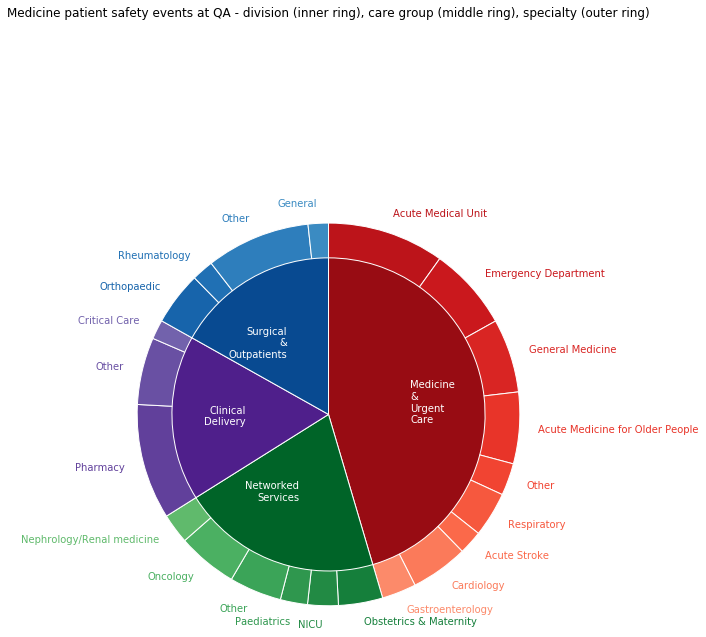

In [92]:
# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
division_colour_dict = {'Medicine & Urgent Care':plt.cm.Reds, 'Networked Services':plt.cm.Greens, 'Surgical & Outpatients':plt.cm.Blues, 'Clinical Delivery':plt.cm.Purples}
inner_ring_colours = [division_colour_dict[division] for division in division_labels]

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=1.9, labels=division_labels_newlines, labeldistance=0.5, colors=[inner_ring_colours[0](0.9), inner_ring_colours[1](0.9), inner_ring_colours[2](0.9), inner_ring_colours[3](0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=1.9, edgecolor='white')
 
# Second Ring (oUTside)
specialty_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    per_division_counts = df_division['division-specialty'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        specialty_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 0.5
mypie2, texts = ax.pie(specialty_counts, radius=2.2, labels=specialty_labels, colors=specialty_colours, textprops={'color':'k'},startangle=90, counterclock=False)
plt.setp( mypie2, width=0.4, edgecolor='white')
for text, color in zip(texts, specialty_colours):
    text.set_color(color)
plt.margins(0,0)

plt.title('Medicine patient safety events at QA - division (inner ring), care group (middle ring), specialty (outer ring)', y=2.3);

In [94]:
df.loc[df.location == 'Department of Critical Care (E5) (DCCQ)', 'location'] = 'E5'
df.loc[df.location == 'Acute Medical Unit (AMU) (MAU)', 'location'] = 'AMU'
df.loc[df.location == 'Haematology & Oncology Day Unit (HODU)', 'location'] = 'HODU'
df.loc[df.location == 'Childrens Assesment Unit (CAU)', 'location'] = 'CAU'
df.loc[df.location == 'Hepatology Clinic (Nurse led) (on C5)', 'location'] = 'Hepatology'
df.loc[df.location == 'Cardiac Day Unit (CDU)', 'location'] = 'CDU'
df.loc[df.location == 'Surgical Assessment Unit (SAU)', 'location'] = 'SAU'
df.location = df.location.str.replace(' QA','')
df.location = df.location.str.replace(' Department','')
df.location = df.location.str.replace(' Unit','')
df.location = df.location.str.replace(' Centre','')
df.location = df.location.str.replace(' Clinic','')
df.location = df.location.str.replace(' and ',' & ')
df.loc[df.location == 'Theatre Admissions Suite (TAS)', 'location'] = 'TAS'
df.loc[df.location == 'Pre-Operative Assessment (POA)', 'location'] = 'POA'
df.loc[df.location == 'Theatre - D1', 'location'] = 'D1'
df.loc[df.location == 'Research & Development', 'location'] = 'R&D'
df.loc[df.location == 'Reception (Atrium)', 'location'] = 'Reception'
df.loc[df.location == 'G5 Endoscopy Suites', 'location'] = 'G5'
df.loc[df.location == 'F3 Stroke Rehabilitation', 'location'] = 'F3'
df.loc[df.location == 'F4 Acute Stroke Ward', 'location'] = 'F4'
df.loc[df.location == 'F1  Neuro Rehab', 'location'] = 'F1'
df.loc[df.location == 'Emergency (ED)', 'location'] = 'ED'
df.loc[df.location == 'B6  Antenatal Ward', 'location'] = 'B6'
df.loc[df.location == 'B7 Postnatal Ward', 'location'] = 'B7'
df.loc[df.location == 'B9 NICU', 'location'] = 'B9'
df.loc[df.location == 'A7 Starfish', 'location'] = 'A7'
df.loc[df.location == 'A8 Shipwreck', 'location'] = 'A8'
df.loc[df.location == 'B5  - Mary Rose Ward', 'location'] = 'B5'
df.loc[df.location == 'B8 Labour Ward', 'location'] = 'B8'
df.loc[df.location == 'Radiotherapy  Dept within CHOC', 'location'] = 'Radiotherapy'
df.loc[df.location == 'Surgical High Care (SHCU)', 'location'] = 'SHCU'

location_counts = df['location'].value_counts()[df['location'].unique()]

location_labels = []
for i in care_group_counts.index:
    df_care_group = df[df.care_group == i]
    per_care_group_counts = df_care_group['location'].value_counts()
    location_labels += [i + ' - ' + str(j) for j in per_care_group_counts.index]

df['division-location'] = df['division'] + ' - ' + df['location']
df['care_group-location'] = df['care_group'] + ' - ' + df['location']

location_counts = df['care_group-location'].value_counts()[df['care_group-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)

for location,percentage in location_percentages.iteritems():
    if percentage < 0.701596 + 0.000001:
        df.loc[df['division-location'] == location, 'division-location'] = location.split(" - ")[0] + ' - Other'

location_counts = df['division-location'].value_counts()[df['division-location'].unique()]
location_percentages = 100*location_counts/sum(location_counts.values)
print(location_percentages)
location_labels_split = location_counts.index.str.split(" - ",n=1)
location_labels = [el[1] for el in location_labels_split]
df_location_percentages = pd.DataFrame(location_percentages)
df_location_percentages['care_group'] = df_location_percentages.index.to_series().str.split(' - ').str[0]
df_care_groups = {}
for care_group in care_group_labels:
    df_care_groups[care_group] = df_location_percentages.loc[df_location_percentages['care_group']==care_group]

Medicine & Urgent Care - AMU                               9.858997
Medicine & Urgent Care - ED                                7.867055
Medicine & Urgent Care - Emergency (Paediatrics)           0.593107
Medicine & Urgent Care - D2                                3.066249
Medicine & Urgent Care - Observation Ward                  0.011191
Medicine & Urgent Care - D3                                1.768129
Medicine & Urgent Care - C6                                3.816025
Medicine & Urgent Care - C5                                2.316473
Medicine & Urgent Care - CDU                               0.649060
Medicine & Urgent Care - E8                                2.260519
Medicine & Urgent Care - E6/7                              1.398836
Medicine & Urgent Care - D7                                0.805730
Medicine & Urgent Care - C7                                1.141450
Medicine & Urgent Care - Cardiology Outpatients            0.134288
Medicine & Urgent Care - Cardiac Catheter Labora

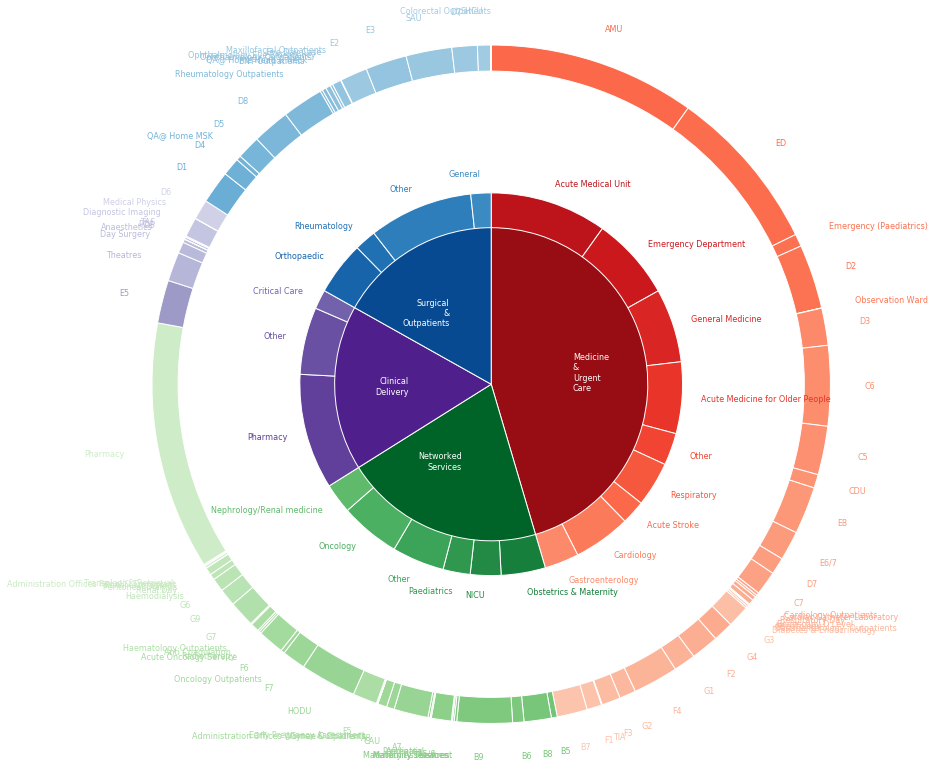

In [96]:
plt.rcParams.update({'font.size': 8})

# Create colors
a, b, c, d, e =[plt.cm.Reds, plt.cm.Oranges, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
a, c, d, e = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Purples]
division_colour_dict = {'Medicine & Urgent Care':plt.cm.Reds, 'Networked Services':plt.cm.Greens, 'Surgical & Outpatients':plt.cm.Blues, 'Clinical Delivery':plt.cm.Purples}
inner_ring_colours = [division_colour_dict[division] for division in division_labels]

# First Ring (Inside)
fig, ax = plt.subplots()
ax.axis('equal')
division_labels_newlines = [i.replace(' ','\n') for i in division_labels]
#mypie, _ = ax.pie(division_counts, radius=2, labels=division_labels_newlines, labeldistance=0.6, colors=[a(0.9), b(0.9), c(0.9), d(0.9), e(0.9)], textprops={'color':'w'})
mypie, _ = ax.pie(division_counts, radius=1.9, labels=division_labels_newlines, labeldistance=0.5, colors=[inner_ring_colours[0](0.9), inner_ring_colours[1](0.9), inner_ring_colours[2](0.9), inner_ring_colours[3](0.9)], textprops={'color':'w'}, startangle=90, counterclock=False)
plt.setp( mypie, width=1.9, edgecolor='white')
 
# Second Ring (oUTside)
specialty_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    per_division_counts = df_division['division-specialty'].value_counts()
    slice_colour = 8
    for j in range(len(per_division_counts)):
        specialty_colours.append(inner_ring_colours[i](slice_colour/10))
        slice_colour -= 0.5
mypie2, texts = ax.pie(specialty_counts, radius=2.2, labels=specialty_labels, colors=specialty_colours, textprops={'color':'k'},startangle=90, counterclock=False)
plt.setp( mypie2, width=0.4, edgecolor='white')
for text, color in zip(texts, specialty_colours):
    text.set_color(color)
plt.margins(0,0)

# Third Ring (oUTside)
location_colours = []
for i,div_index in enumerate(division_counts.index):
    df_division = df[df.division == div_index]
    slice_colour_orig = 0.5
    division_care_group_counts = df_division['care_group'].value_counts()[df_division['care_group'].unique()]
    for j,care_index in enumerate(division_care_group_counts.index):
        df_care_group = df_division[df_division['care_group-location'].str.startswith(care_index)]
        per_care_group_counts = df_care_group['care_group-location'].value_counts()[df_care_group['care_group-location'].unique()]
        slice_colour = slice_colour_orig - j/10
        for k in per_care_group_counts:
            location_colours.append(inner_ring_colours[i](slice_colour))
            slice_colour -= 0.01
mypie3, texts = ax.pie(location_counts, radius=3.9, labels=location_labels, colors=location_colours, startangle=90, counterclock=False)
plt.setp( mypie3, width=0.3, edgecolor='white')
for text, color in zip(texts, location_colours):
    text.set_color(color)
plt.margins(0,0)